In [1]:
cd /mnt/sda/otani/Experiments/moment_retrieval

/mnt/sda/otani/Experiments/moment_retrieval


In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import spacy
import matplotlib.pyplot as plt
from src.toolbox.utils import _nms, sentence2token
from src.toolbox.eval import evaluate, location_error, accumulate_metrics, categorize_results, summarize_results_per_class
from src.toolbox.utils import _nms
from src.toolbox.visualization import plot_performance_per_class, plot_performance_per_duration
from src.toolbox.data_converters import Charade2Instances
from src.toolbox.baseline import SegmentGeneratorKDE, predict
import pickle as pkl

In [3]:
# load ground truth testset
test_data = Charade2Instances(pd.read_csv('data/processed/test.csv'))

In [4]:
# load predictions by 2D-TAN
predictions = pkl.load(open("/home/otani_mayu/3TDisk/Experiments/2D-TAN/results/Charades/TAN_vgg_rgb_test.pkl", "rb"))

In [5]:
# evaluate R@K (IoU>m)
preds = []
for p in predictions:
    query = (p[0][0], p[0][1]+".") # 2D-TAN remove '.' in description. Add to recover original input description.
    seg = p[1]
    keep = _nms(np.asarray(seg), np.arange(len(seg))[::-1], thresh=0.5, top_k=5)
    seg = [seg[i] for i in keep]
    preds.append((query, seg, np.arange(len(seg))[::-1].tolist()))
results = evaluate(test_data, preds)
summary = accumulate_metrics(results)

pkl.dump(results,
        open("reports/figure_src/results/charade/2d-tan.pkl", "wb"))

R@1 IoU>0.3 0.57
R@1 IoU>0.5 0.42
R@1 IoU>0.7 0.22
R@5 IoU>0.3 0.92
R@5 IoU>0.5 0.80
R@5 IoU>0.7 0.51
R@10 IoU>0.3 0.92
R@10 IoU>0.5 0.80
R@10 IoU>0.7 0.51


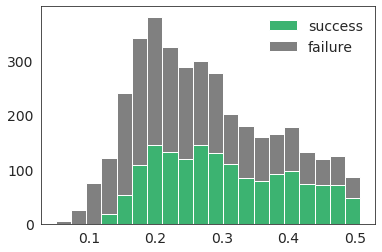

In [6]:
# Check relation between success rates and iput video durations
plt.rcParams.update({'font.size': 14})
fig = plot_performance_per_duration(results, test_data, ax=plt.gca())
plt.savefig("reports/figures/detailed_analysis/charade/performance_per_duration/2d-tan.pdf", bbox_inches="tight")

In [7]:
# per-action performance
from src.toolbox.eval import get_first_action, categorize_results, summarize_results_per_class
from src.toolbox.utils import _load_top_actions
top_actions = _load_top_actions("charade")
cat_fn = lambda x: get_first_action(x, top_actions)
categorized_results = categorize_results(results, cat_fn)
metrics_per_cls = summarize_results_per_class(categorized_results)
pkl.dump(metrics_per_cls, open("reports/figure_src/metrics_per_cls/charade/2d-tan.pkl", "wb"))

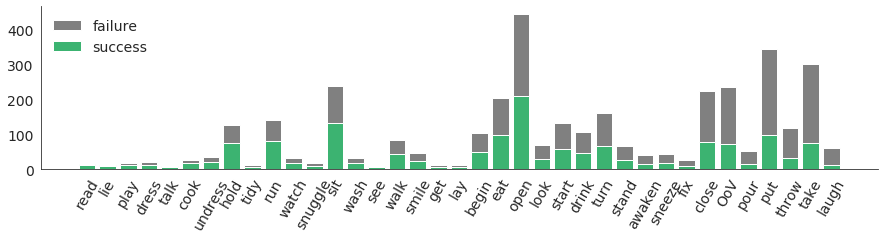

In [8]:
metrics_per_cls = pkl.load(open("reports/figure_src/metrics_per_cls/charade/2d-tan.pkl", "rb"))
class_labels = list(metrics_per_cls.keys())
frequent_class = [label for label in class_labels if metrics_per_cls[label]["n_instance"] > 10]
_ = plot_performance_per_class({l: v for l, v in metrics_per_cls.items() if l in frequent_class})
plt.savefig("reports/figures/detailed_analysis/charade/performance_per_cls/2d-tan.pdf", bbox_inches="tight")